<h2 style="text-align: center;"><strong>Projet Big Data : Analyse des sentiments</strong></h2>
<h3 style="text-align: left;">Réalisé par  :</h3>
<ul>
<li>ARI Chaymaa</li>
<li>ASSAG Khadija</li>
</ul>
<h3>Encadré par :</h3>
<ul>
    <li><p>Prof : SOUSSI Nassima</p>
        

</ul>

### <b>Les bibliothèques :</b>

In [1]:
#!pip install pyspark



In [2]:
#!pip install when

### <b>Création d'une session Spark nommée "NB"</b>

In [3]:
## Creating the spark session
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import udf
import re
from string import punctuation
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace, lower, col, concat_ws, split, array_except , lit ,collect_list
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

In [4]:

spark =SparkSession.builder.appName("NB").getOrCreate()

In [5]:
# Accéder à l'objet SparkContext via la session
sc = spark.sparkContext

# Obtenir la configuration Spark
spark_conf = sc.getConf()

# Afficher la configuration Spark
for conf in spark_conf.getAll():
    print(conf)

('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.driver.port', '33591')
('spark.executor.id', 'driver')
('spark.app.submitTime', '1735581874153')
('

### <b>Chargement des données depuis des fichiers CSV dans Spark</b>

In [6]:
##  DATA LOADING
df_train = spark.read.csv('/content/train.csv', inferSchema=True, header=True ,encoding="ISO-8859-1")
df_test = spark.read.csv('/content/test.csv', inferSchema=True, header=True ,encoding="ISO-8859-1")

In [7]:
print("train dataset")
df_train.show()

train dataset
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|       selected_text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km²)|Density (P/Km²)|
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|cb774db0d1| I`d have respond...|I`d have responde...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|549e992a42| Sooo SAD I will ...|            Sooo SAD| negative|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|088c60f138|my boss is bullyi...|         bullying me| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|9642c003ef| what intervie

In [8]:
print("test dataset")
df_test.show()

test dataset
+----------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km²)|Density (P/Km²)|
+----------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|f87dea47db|Last session of t...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|96d74cb729| Shanghai is also...| positive|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|eee518ae67|Recession hit Ver...| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|01082688c6|         happy bday!| positive|      morning|      46-60|            Andorra|           77265|          470.0|            164|
|33987a8ee5| h

# <b> Partie 1:Prétraitement </b>

### <b>Suppression des valeurs nulles et comptage des lignes</b>

In [9]:
## Supprimer les nulls
# Afficher le nombre de lignes dans l'ensemble d'entraînement
# Supprimer les nulls
df_train= df_train.dropna()
df_train_count = df_train.count()
print("Nombre de lignes dans l'ensemble d'entraînement:", df_train_count)

# Afficher le nombre de lignes dans l'ensemble test
# Supprimer les nulls
df_test = df_test.dropna()
df_test_count = df_test.count()
print("Nombre de lignes dans l'ensemble d'entraînement:", df_test_count)

Nombre de lignes dans l'ensemble d'entraînement: 48795
Nombre de lignes dans l'ensemble d'entraînement: 3534


### <b>Sélectionner uniquement les colonnes 'text' et 'sentiment' dans les ensembles d'entraînement et de test, puis les fusionner et afficher le DataFrame</b>

In [10]:
df_train=df_train['text', 'sentiment']
df_test=df_test['text', 'sentiment']
df = df_train.union(df_test)
df.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
| I`d have respond...|  neutral|
| Sooo SAD I will ...| negative|
|my boss is bullyi...| negative|
| what interview! ...| negative|
| Sons of ****, wh...| negative|
|http://www.dotheb...|  neutral|
|2am feedings for ...| positive|
|          Soooo high|  neutral|
|         Both of you|  neutral|
| Journey!? Wow......| positive|
| as much as i lov...|  neutral|
|I really really l...| positive|
|My Sharpie is run...| negative|
|i want to go to m...| negative|
|test test from th...|  neutral|
|Uh oh, I am sunbu...| negative|
| S`ok, trying to ...| negative|
|i`ve been sick fo...| negative|
|is back home now ...| negative|
|Hes just not that...|  neutral|
+--------------------+---------+
only showing top 20 rows



### <b>supprimer les duplications dans le DataFrame et afficher les statistiques descriptives avant et après la suppression</b>

In [11]:
##Affichage des statistiques descriptive avant suppression
print("Avant supression :")
df.describe().show()
## Supprimer les duplications
df = df.dropDuplicates()
##Affichage des statistiques descriptive apres suppression
print("Après supression :")
df.describe().show()

Avant supression :
+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               52329|    52329|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|\tREALLY?? oh.. s...|      ave|
|    max|Ã¯Â¿Â½Ã¯Â¿Â½h. iÃ...| positive|
+-------+--------------------+---------+

Après supression :
+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               31013|    31013|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|\tREALLY?? oh.. s...|      ave|
|    max|Ã¯Â¿Â½Ã¯Â¿Â½h. iÃ...| positive|
+-------+--------------------+---------+



### <b>Visualiser le nombre de sentiments différents</b>

In [12]:
#visualiser les sentiment
df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive| 9685|
|  neutral|12547|
| negative| 8780|
|      ave|    1|
+---------+-----+



### <b>Encodage des sentiments et visualisation</b>

In [13]:
## Encoder les sentiments
# Définir le dictionnaire de remplacement
replacement_dict = {"positive": 1, "neutral": 0, "negative": 2}

# Remplacer les valeurs dans la colonne "sentiment" en fonction du dictionnaire de remplacement
df = df.withColumn("sentiment",
                   when(df["sentiment"] == "positive", replacement_dict["positive"])
                   .when(df["sentiment"] == "neutral", replacement_dict["neutral"])
                   .when(df["sentiment"] == "negative", replacement_dict["negative"])
                   .otherwise(df["sentiment"]))
#visualiser les sentiment
# Convertir la colonne "sentiment" en type entier
df = df.withColumn("sentiment", col("sentiment").cast("int"))

df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|        1| 9685|
|        2| 8780|
|        0|12547|
|     NULL|    1|
+---------+-----+



### <b>Visualisation du décompte des sentiments</b>

In [14]:
import pyspark
import pandas as pd
print("Spark Version:", pyspark.__version__)
print("Pandas Version:", pd.__version__)


Spark Version: 3.5.4
Pandas Version: 2.2.2


In [15]:
print("Nombre de lignes:", df.count())
print("Nombre de colonnes:", len(df.columns))


Nombre de lignes: 31013
Nombre de colonnes: 2


In [16]:
pip install pyspark --upgrade

<Axes: xlabel='sentiment', ylabel='count'>

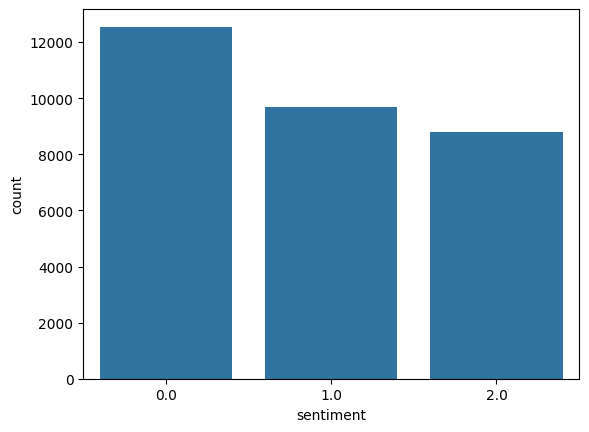

In [17]:
## Visualizing the count
# Conversion du DataFrame Spark en DataFrame Pandas
df_pandas=df.toPandas()

# Utilisation de Seaborn pour tracer le décompte des sentiments
sns.countplot(x='sentiment',data=df_pandas)

### <b>Échantillonnage pour équilibrer les classes de sentiments</b>

In [18]:
#Inference: The data is unbalanced therfore we will downsample the data to have same count for each sentiment
# Séparer les classes majoritaires et minoritaires
df_majority = df.filter(col("sentiment") == 0)
df_minority = df.filter(col("sentiment") == 2)
df_medium = df.filter(col("sentiment") == 1)

# Déterminer la taille de l'échantillon de la classe minoritaire
minority_count = df_minority.count()

# Échantillonnage aléatoire des données de la classe majoritaire pour correspondre à la taille de la classe minoritaire
df_majority_downsampled = df_majority.sample(False, minority_count / df_majority.count(), seed=1234)
df_medium_downsampled = df_medium.sample(False, minority_count / df_medium.count(), seed=1234)

# Combinez les classes majoritaires échantillonnées et les classes minoritaires
df = df_majority_downsampled.union(df_minority).union(df_medium_downsampled)


### <b>Visualisation des sentiments avant et après l'équilibrage des classes</b>

+---------+-----+
|sentiment|count|
+---------+-----+
|        0| 8797|
|        2| 8780|
|        1| 8809|
+---------+-----+



<Axes: xlabel='sentiment', ylabel='count'>

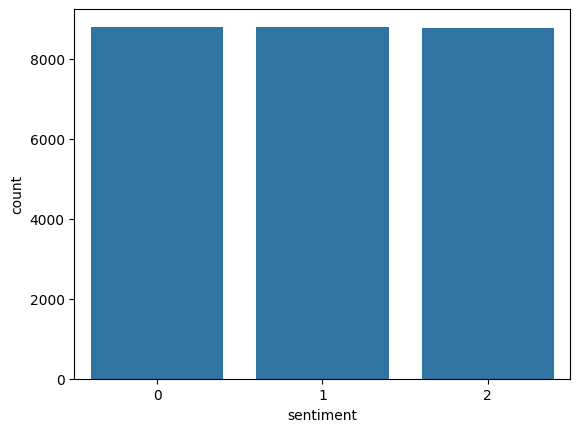

In [19]:
#visualiser les sentiment
df.groupBy('sentiment').count().show()

df_pandas=df.toPandas()
sns.countplot(x='sentiment',data=df_pandas)

### <b>Transformation de la colonne de texte</b>

In [20]:
# Appliquer les transformations sur la colonne de texte
## Convertir le texte en minuscules
df = df.withColumn('processed_text', lower(df['text']))
# Supprimer les crochets et leur contenu
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\[.*?\\]', ''))

# Supprimer les caractères non alphanumériques
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\W', ' '))
### Supprimer les URLs
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], 'https?://\\S+|www\\.\\S+', ''))
## Supprimer les balises HTML
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '<.*?>+', ''))
## Supprimer les ponctuations
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '[%s]' % re.escape(string.punctuation), ''))
## Supprimer les sauts de ligne
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\n', ''))
#
# Supprimer les chiffres et les mots contenant des chiffres
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\w*\\d\\w*', ''))


### <b>Suppression des stopwords et formation du texte final</b>

In [21]:
# Télécharger la liste des stopwords si nécessaire
nltk.download('stopwords')

# Charger la liste des stopwords en français par exemple
stop_words = set(stopwords.words('english'))

## delete stop words

# Diviser le texte en mots
df = df.withColumn('words', split(df['processed_text'], ' '))

# Charger la liste des stopwords en tant qu'ensemble pour une recherche efficace
stop_words_set = set(stop_words)

# Convertir l'ensemble de stopwords en liste
stop_words_list = list(stop_words_set)

# Créer une colonne contenant la liste des mots
stop_words_col = lit(stop_words_list)

# Filtrer les mots qui ne sont pas des stopwords
df = df.withColumn('processed_words', array_except(col('words'), stop_words_col))

# Joindre les mots filtrés pour former le texte final
df = df.withColumn('processed_text', concat_ws(' ', col('processed_words')))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### <b>Affichage de la colonne 'processed_text'</b>

In [22]:
# Afficher uniquement la colonne 'processed_text'
df.select('processed_text').show(truncate=False)


+-----------------------------------------------------------------------------------------+
|processed_text                                                                           |
+-----------------------------------------------------------------------------------------+
| go cruches next weeks                                                                   |
|coffee time  back later kisses                                                           |
| heeeey dear finally found                                                               |
| last night                                                                              |
|back uminaa                                                                              |
|grandpa telling used cut human bodies med school                                         |
|nuggets game everyoneeeee except                                                         |
| ya never watch l                                                              

### <b>Agrégation des textes par sentiment et création de nuages de mots</b>

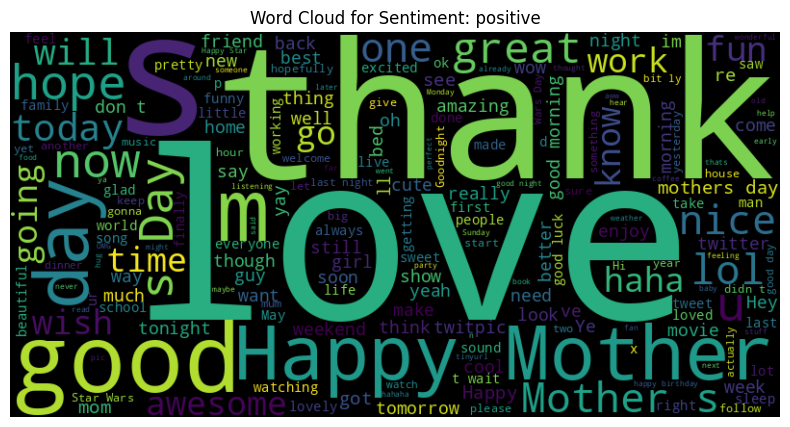

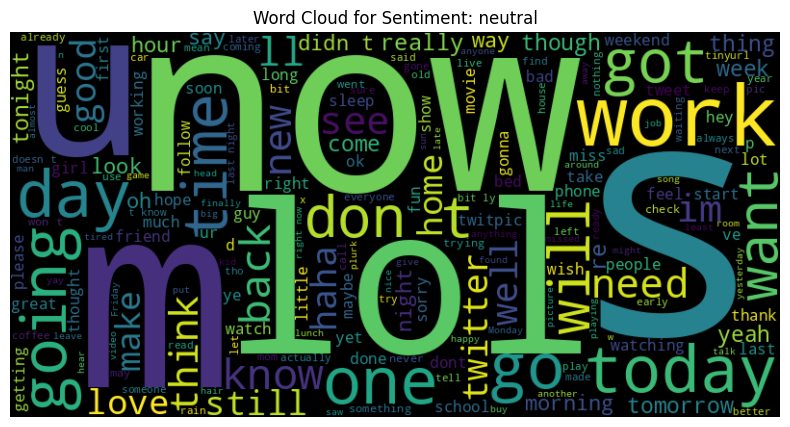

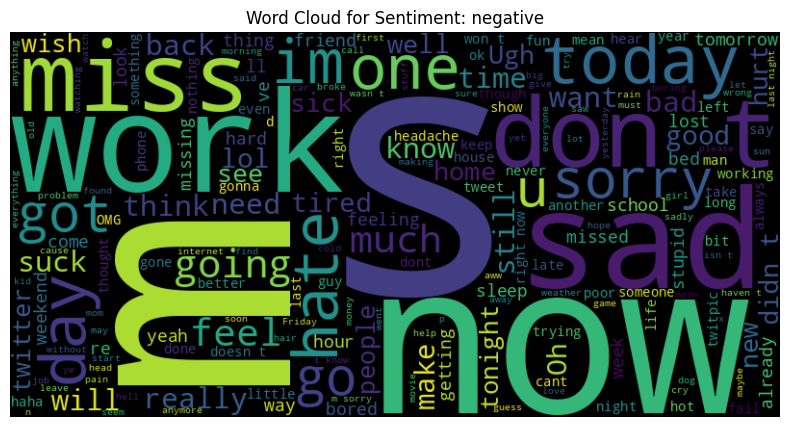

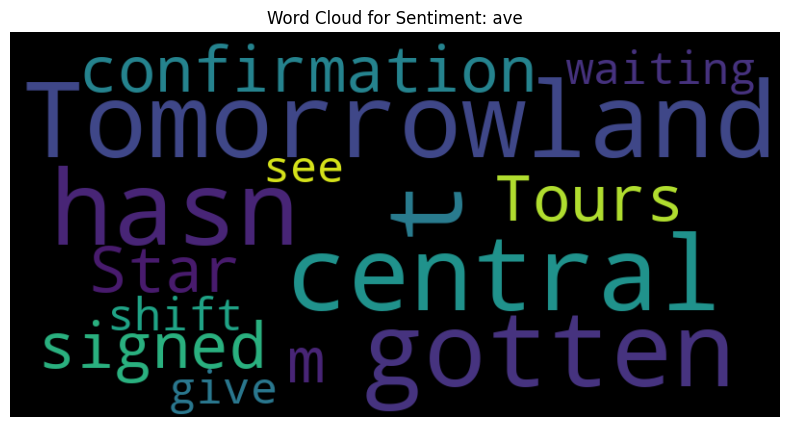

In [23]:
# Agréger les textes en fonction du sentiment
aggregated_df = df_train.groupby('sentiment').agg(concat_ws(' ', collect_list('text')).alias('text'))

# Convertir l'aggregated_df en Pandas DataFrame pour utiliser WordCloud
aggregated_pd_df = aggregated_df.toPandas()

# Créer un nuage de mots pour chaque sentiment
for index, row in aggregated_pd_df.iterrows():
    sentiment = row['sentiment']
    text = row['text']
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Sentiment: {sentiment}')
    plt.axis('off')
    plt.show()

In [24]:
# Diviser les données en ensembles de formation et de test
train_data, test_data ,val_data= df.randomSplit([0.7, 0.1,0.2], seed=42)

In [25]:
# Vérifier les tailles des ensembles
#print("Nombre de lignes dans l'ensemble d'entraînement :", train_data.count())
#print("Nombre de lignes dans l'ensemble de validation :", val_data.count())
#print("Nombre de lignes dans l'ensemble de test :", test_data.count())

In [26]:
from pyspark.sql.functions import concat_ws, col
from pyspark.sql.types import ArrayType

# Identifier et convertir toutes les colonnes de type ARRAY<STRING>
for column, dtype in train_data.dtypes:
    if dtype.startswith("array"):
        # Transformer ARRAY<STRING> en STRING
        train_data = train_data.withColumn(column, concat_ws(" ", col(column)))
        val_data = val_data.withColumn(column, concat_ws(" ", col(column)))
        test_data = test_data.withColumn(column, concat_ws(" ", col(column)))

# Sauvegarder les ensembles au format CSV
train_data.write.csv("train_data.csv", header=True, mode="overwrite")
val_data.write.csv("val_data.csv", header=True, mode="overwrite")
test_data.write.csv("test_data.csv", header=True, mode="overwrite")

print("Les ensembles de données ont été enregistrés en tant que fichiers CSV.")

Les ensembles de données ont été enregistrés en tant que fichiers CSV.


In [27]:
pip install tensorflow

In [28]:
print(df_pandas.columns)


Index(['text', 'sentiment'], dtype='object')


## CNN (1D)

In [29]:
!pip install keras


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Charger les données
train_texts = df_pandas['text'].values
train_labels = df_pandas['sentiment'].values

# Paramètres de tokenization
max_words = 20000  # Nombre maximum de mots dans le vocabulaire
max_len = 100      # Longueur maximale des séquences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

# Padding des séquences
X = pad_sequences(sequences, maxlen=max_len)

# Encodage des labels en format one-hot
encoder = OneHotEncoder(sparse_output=False)

y = encoder.fit_transform(train_labels.reshape(-1, 1))

# Diviser en ensembles de formation, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convertir les données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Créer un Dataset PyTorch
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Construire le modèle PyTorch
class CNN1D(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(CNN1D, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv1d = nn.Conv1d(in_channels=embed_size, out_channels=64, kernel_size=5)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # Convertir en [batch_size, embed_size, seq_len]
        x = torch.relu(self.conv1d(x))
        x = self.global_max_pool(x).squeeze(-1)  # [batch_size, out_channels]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

# Initialiser le modèle
model = CNN1D(vocab_size=max_words, embed_size=128, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, torch.argmax(y_batch, dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == y_batch.argmax(dim=1)).float().mean().item()

        val_loss, val_acc = 0, 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, torch.argmax(y_batch, dim=1))

                val_loss += loss.item()
                val_acc += (outputs.argmax(dim=1) == y_batch.argmax(dim=1)).float().mean().item()

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Acc: {val_acc/len(val_loader):.4f}")

# Appeler la fonction d'entraînement
train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Train Loss: 1.0122, Train Acc: 0.4985, Val Loss: 0.9448, Val Acc: 0.5817
Epoch 2/50, Train Loss: 0.8865, Train Acc: 0.6497, Val Loss: 0.9118, Val Acc: 0.6199
Epoch 3/50, Train Loss: 0.8177, Train Acc: 0.7266, Val Loss: 0.8992, Val Acc: 0.6335
Epoch 4/50, Train Loss: 0.7662, Train Acc: 0.7829, Val Loss: 0.8925, Val Acc: 0.6436
Epoch 5/50, Train Loss: 0.7306, Train Acc: 0.8195, Val Loss: 0.8987, Val Acc: 0.6368
Epoch 6/50, Train Loss: 0.7055, Train Acc: 0.8453, Val Loss: 0.8871, Val Acc: 0.6540
Epoch 7/50, Train Loss: 0.6914, Train Acc: 0.8595, Val Loss: 0.8877, Val Acc: 0.6558
Epoch 8/50, Train Loss: 0.6800, Train Acc: 0.8706, Val Loss: 0.8914, Val Acc: 0.6546
Epoch 9/50, Train Loss: 0.6704, Train Acc: 0.8800, Val Loss: 0.8889, Val Acc: 0.6513
Epoch 10/50, Train Loss: 0.6619, Train Acc: 0.8895, Val Loss: 0.8914, Val Acc: 0.6530
Epoch 11/50, Train Loss: 0.6568, Train Acc: 0.8939, Val Loss: 0.8970, Val Acc: 0.6480
Epoch 12/50, Train Loss: 0.6542, Train Acc: 0.8973, Val Loss: 0

In [31]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, data_loader, criterion):
    model.eval()  # Met le modèle en mode évaluation
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, torch.argmax(y_batch, dim=1))
            total_loss += loss.item()

            # Stocker les vraies classes et les prédictions
            all_targets.extend(torch.argmax(y_batch, dim=1).cpu().numpy())
            all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    # Calculer la perte moyenne et la précision
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_targets, all_predictions)

    # Afficher le rapport détaillé
    print("Classification Report:")
    print(classification_report(all_targets, all_predictions))

    return avg_loss, accuracy


In [32]:
# Évaluer sur l'ensemble d'entraînement
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
print(f"Performance sur l'ensemble d'entraînement : Perte = {train_loss:.4f}, Précision = {train_accuracy:.4f}")

# Évaluer sur l'ensemble de validation
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
print(f"Performance sur l'ensemble de validation : Perte = {val_loss:.4f}, Précision = {val_accuracy:.4f}")

# Évaluer sur l'ensemble de test
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Performance sur l'ensemble de test : Perte = {test_loss:.4f}, Précision = {test_accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      6170
           1       0.95      0.93      0.94      6131
           2       0.92      0.95      0.93      6169

    accuracy                           0.94     18470
   macro avg       0.94      0.94      0.94     18470
weighted avg       0.94      0.94      0.94     18470

Performance sur l'ensemble d'entraînement : Perte = 0.6148, Précision = 0.9367
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1308
           1       0.77      0.70      0.73      1314
           2       0.66      0.74      0.70      1336

    accuracy                           0.66      3958
   macro avg       0.66      0.66      0.66      3958
weighted avg       0.66      0.66      0.66      3958

Performance sur l'ensemble de validation : Perte = 0.8897, Précision = 0.6594
Classification Report:
            

In [38]:
# Sauvegarder le modèle
torch.save(model.state_dict(), "CNN_Model.pth")
print("Le modèle a été sauvegardé avec succès.")

Le modèle a été sauvegardé avec succès.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [39]:
new_texts = ["I love this!", "This is terrible!", "It’s okay."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_len)


# Sauvegarder le modèle
torch.save(model.state_dict(), "modele_sentiment.pth")
print("Le modèle a été sauvegardé avec succès.")





Le modèle a été sauvegardé avec succès.


## CNN 2D

In [40]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv2D, GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Charger les données
train_texts = df_pandas['text'].values
train_labels = df_pandas['sentiment'].values

# Paramètres de tokenization
max_words = 20000  # Nombre maximum de mots dans le vocabulaire
max_len = 100      # Longueur maximale des séquences

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

# Padding des séquences
X = pad_sequences(sequences, maxlen=max_len)

# Représentation des séquences en 2D (matrices) - ajouter une "dimension de canal"
X = X.reshape(X.shape[0], X.shape[1], 1, 1)  # Format (samples, height, width, channels)

# Encodage des labels en format one-hot
y = to_categorical(train_labels, num_classes=3)

# Diviser en ensembles de formation, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Construire le modèle CNN 2D
model = Sequential([
    Conv2D(64, kernel_size=(3, 1), activation='relu', input_shape=(max_len, 1, 1)),
    Dropout(0.5),
    Conv2D(64, kernel_size=(3, 1), activation='relu'),
    GlobalMaxPooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes pour les sentiments
])


# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 1, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 1, 64)           │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,963 (66.26 KB)

 Trainable params: 16,963 (66.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.3304 - loss: 87.1087 - val_accuracy: 0.3320 - val_loss: 1.0988
Epoch 2/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3308 - loss: 1.2880 - val_accuracy: 0.3320 - val_loss: 1.0986
Epoch 3/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3370 - loss: 1.1334 - val_accuracy: 0.3375 - val_loss: 1.0986
Epoch 4/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3363 - loss: 1.1042 - val_accuracy: 0.3305 - val_loss: 1.0986
Epoch 5/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3353 - loss: 1.1088 - val_accuracy: 0.3305 - val_loss: 1.0986
Epoch 6/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3244 - loss: 1.1225 - val_accuracy: 0.3305 - val_loss: 1.0986
Epoch 7/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3268 - loss: 1.1097 - val_accuracy: 0.3305 - val_loss: 1.0986
Epoch 8/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3316 - loss: 1.0986 - va

In [41]:
# Évaluer le modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3293 - loss: 1.0987
Loss: 1.0985578298568726
Accuracy: 0.3446184992790222


In [42]:
# Ajouter les dimensions manquantes
new_padded_reshaped = np.expand_dims(new_padded, axis=-1)  # Ajoute une dimension à la fin
new_padded_reshaped = np.expand_dims(new_padded_reshaped, axis=-1)  # Ajoute une autre dimension

# Faire la prédiction
predictions = model.predict(new_padded_reshaped)

# Afficher les résultats
for text, pred in zip(new_texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {np.argmax(pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Text: I love this!
Predicted Sentiment: 1
Text: This is terrible!
Predicted Sentiment: 1
Text: It’s okay.
Predicted Sentiment: 1


## CNN 3D

In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Charger les données
train_texts = df_pandas['text'].values
train_labels = df_pandas['sentiment'].values

# Paramètres de tokenization
max_words = 20000  # Nombre maximum de mots dans le vocabulaire
max_len = 100      # Longueur maximale des séquences
embedding_dim = 128  # Taille des vecteurs d'embedding

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

# Padding des séquences
X = pad_sequences(sequences, maxlen=max_len)

# Ajouter une dimension pour les embeddings (simuler 3D)
X = np.expand_dims(X, axis=-1)  # Ajoute une dimension supplémentaire
X = np.expand_dims(X, axis=-1)  # Ajoute une deuxième dimension supplémentaire pour CNN 3D

# Encodage des labels en format one-hot
y = to_categorical(train_labels, num_classes=3)



# Préparer les données pour CNN 3D
X = np.expand_dims(X, axis=-1)  # Forme devient (num_samples, max_len, 1, 1)
X = np.expand_dims(X, axis=2)  # Forme devient (num_samples, max_len, 1, 1, 1)

# Nouvelle forme attendue : (max_len, 1, 1, 1)

# Construire le modèle CNN 3D
model = Sequential([
    Conv3D(32, kernel_size=(3, 1, 1), activation='relu', input_shape=(max_len, 1, 1, 1)),  # Ajuster kernel_size
    MaxPooling3D(pool_size=(2, 1, 1)),  # Ajuster le pooling pour éviter les dimensions négatives
    Dropout(0.5),
    Conv3D(64, kernel_size=(3, 1, 1), activation='relu'),
    MaxPooling3D(pool_size=(2, 1, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes pour les sentiments
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 98, 1, 1, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 49, 1, 1, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 49, 1, 1, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 47, 1, 1, 64)        │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 23, 1, 1, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         188,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,267 (762.76 KB)

 Trainable params: 195,267 (762.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.3464 - loss: 51.8579 - val_accuracy: 0.3456 - val_loss: 1.1181
Epoch 2/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.3348 - loss: 1.1736 - val_accuracy: 0.3345 - val_loss: 1.1011
Epoch 3/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.3338 - loss: 1.1248 - val_accuracy: 0.3320 - val_loss: 1.0991
Epoch 4/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.3370 - loss: 1.1069 - val_accuracy: 0.3373 - val_loss: 1.0999
Epoch 5/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.3318 - loss: 1.1065 - val_accuracy: 0.3375 - val_loss: 1.0993
Epoch 6/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.3315 - loss: 1.1037 - val_accuracy: 0.3320 - val_loss: 1.1004
Epoch 7/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.3207 - loss: 1.1087 - val_accuracy: 0.3305 - val_loss: 1.0987
Epoch 8/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.3345 - loss: 1.0998 -

In [44]:
# Évaluer le modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3350 - loss: 1.1384
Loss: 1.1357555389404297
Accuracy: 0.3324911594390869


In [45]:
# Prétraitement des nouveaux textes
new_texts = ["I love this!", "This is terrible!", "It’s okay."]

new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Redimensionner pour correspondre à l'entrée du modèle CNN 3D
new_padded = np.expand_dims(new_padded, axis=-1)  # Ajoute une dimension à la fin -> (3, 100, 1)
new_padded = np.expand_dims(new_padded, axis=2)   # Ajoute une autre dimension -> (3, 100, 1, 1)
new_padded = np.expand_dims(new_padded, axis=-1)  # Forme finale : (3, 100, 1, 1, 1)

# Prédictions
predictions = model.predict(new_padded)

# Afficher les prédictions
for text, pred in zip(new_texts, predictions):
    predicted_class = np.argmax(pred)  # Classe prédite
    print(f"Texte : {text} | Prédiction : {predicted_class} | Probabilités : {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Texte : I love this! | Prédiction : 0 | Probabilités : [0.3360276  0.3309331  0.33303937]
Texte : This is terrible! | Prédiction : 0 | Probabilités : [0.3360276  0.3309331  0.33303937]
Texte : It’s okay. | Prédiction : 0 | Probabilités : [0.3360276  0.3309331  0.33303937]


In [46]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paramètres
max_words = 20000  # Taille du vocabulaire
max_len = 100      # Longueur maximale des séquences
embedding_dim = 128
num_classes = 3    # Nombre de classes (par exemple, sentiment)

# Charger les données
train_texts = df_pandas['text'].values
train_labels = df_pandas['sentiment'].values

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
X = pad_sequences(sequences, maxlen=max_len)

# Encodage des labels
y = to_categorical(train_labels, num_classes=num_classes)

# Diviser les données en ensembles de formation, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Construire le modèle CNN + LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),

    # Partie CNN
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Dropout(0.5),

    # Partie LSTM
    LSTM(100, return_sequences=False),
    Dropout(0.5),

    # Partie Dense pour la classification
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Classification multi-classes
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Évaluation sur les données de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - accuracy: 0.4815 - loss: 0.9783 - val_accuracy: 0.6961 - val_loss: 0.7020
Epoch 2/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7645 - loss: 0.5740 - val_accuracy: 0.7175 - val_loss: 0.6635
Epoch 3/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8579 - loss: 0.3857 - val_accuracy: 0.7094 - val_loss: 0.7213
Epoch 4/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.9035 - loss: 0.2743 - val_accuracy: 0.7049 - val_loss: 0.8971
Epoch 5/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 80s 71ms/step - accuracy: 0.9305 - loss: 0.1951 - val_accuracy: 0.7062 - val_loss: 0.9781
Epoch 6/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9462 - loss: 0.1600 - val_accuracy: 0.6948 - val_loss: 1.1555
Epoch 7/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9573 - loss: 0.1296 - val_accuracy: 0.6953 - val_loss: 1.1472
Epoch 8/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.9664 - loss: 0.0999 - 